***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.2)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_3_4')

FOLDER CREATED =  ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_4


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 32
    SCap_c_dims = 64


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 7)           0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 10)           0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 2)            0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 2)           0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 10)          0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 10)          0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.2318 - prediction_coarse_accuracy: 0.8823 - prediction_medium_accuracy: 0.6090 - prediction_fine_accuracy: 0.4851
  • Coarse Accuracy = 88.23% | Val_Accuracy = 92.15% | LossWeight = 0.18 
  • Medium Accuracy = 60.90% | Val_Accuracy = 70.51% | LossWeight = 0.41 
  • Fine   Accuracy = 48.51% | Val_Accuracy = 58.64% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.58640, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_4\epoch-best.h5
781/781 [==============================] - 121s 132ms/step - loss: 0.2318 - prediction_coarse_accuracy: 0.8823 - prediction_medium_accuracy: 0.6090 - prediction_fine_accuracy: 0.4851 - val_loss: 0.1630 - val_prediction_coarse_accuracy: 0.9215 - val_prediction_medium_accuracy: 0.7051 - val_prediction_fine_accuracy: 0.5864 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1420 - prediction_coarse_accuracy: 0.9298

Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0779 - prediction_coarse_accuracy: 0.9712 - prediction_medium_accuracy: 0.9109 - prediction_fine_accuracy: 0.8773
  • Coarse Accuracy = 97.12% | Val_Accuracy = 97.52% | LossWeight = 0.18 
  • Medium Accuracy = 91.09% | Val_Accuracy = 89.76% | LossWeight = 0.40 
  • Fine   Accuracy = 87.73% | Val_Accuracy = 85.92% | LossWeight = 0.41 

Epoch 10: val_prediction_fine_accuracy improved from 0.85130 to 0.85920, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_4\epoch-best.h5
781/781 [==============================] - 104s 133ms/step - loss: 0.0779 - prediction_coarse_accuracy: 0.9712 - prediction_medium_accuracy: 0.9109 - prediction_fine_accuracy: 0.8773 - val_loss: 0.0525 - val_prediction_coarse_accuracy: 0.9752 - val_prediction_medium_accuracy: 0.8976 - val_prediction_fine_accuracy: 0.8592 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.0761 - prediction_coarse_accuracy: 

781/781 [==============================] - ETA: 0s - loss: 0.0620 - prediction_coarse_accuracy: 0.9806 - prediction_medium_accuracy: 0.9490 - prediction_fine_accuracy: 0.9319
  • Coarse Accuracy = 98.06% | Val_Accuracy = 98.24% | LossWeight = 0.21 
  • Medium Accuracy = 94.90% | Val_Accuracy = 91.89% | LossWeight = 0.39 
  • Fine   Accuracy = 93.19% | Val_Accuracy = 88.70% | LossWeight = 0.39 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.89030
781/781 [==============================] - 96s 122ms/step - loss: 0.0620 - prediction_coarse_accuracy: 0.9806 - prediction_medium_accuracy: 0.9490 - prediction_fine_accuracy: 0.9319 - val_loss: 0.0424 - val_prediction_coarse_accuracy: 0.9824 - val_prediction_medium_accuracy: 0.9189 - val_prediction_fine_accuracy: 0.8870 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0615 - prediction_coarse_accuracy: 0.9811 - prediction_medium_accuracy: 0.9506 - prediction_fine_accuracy: 0.9331
  • Coa

781/781 [==============================] - 99s 127ms/step - loss: 0.0576 - prediction_coarse_accuracy: 0.9833 - prediction_medium_accuracy: 0.9594 - prediction_fine_accuracy: 0.9492 - val_loss: 0.0368 - val_prediction_coarse_accuracy: 0.9854 - val_prediction_medium_accuracy: 0.9323 - val_prediction_fine_accuracy: 0.9000 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0568 - prediction_coarse_accuracy: 0.9832 - prediction_medium_accuracy: 0.9593 - prediction_fine_accuracy: 0.9490
  • Coarse Accuracy = 98.32% | Val_Accuracy = 98.51% | LossWeight = 0.23 
  • Medium Accuracy = 95.93% | Val_Accuracy = 93.00% | LossWeight = 0.40 
  • Fine   Accuracy = 94.90% | Val_Accuracy = 89.98% | LossWeight = 0.37 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.90000
781/781 [==============================] - 101s 130ms/step - loss: 0.0568 - prediction_coarse_accuracy: 0.9832 - prediction_medium_accuracy: 0.9593 - prediction_fine_accuracy: 0.9490

Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.0560 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9551
  • Coarse Accuracy = 98.38% | Val_Accuracy = 98.68% | LossWeight = 0.24 
  • Medium Accuracy = 96.28% | Val_Accuracy = 93.27% | LossWeight = 0.40 
  • Fine   Accuracy = 95.51% | Val_Accuracy = 90.17% | LossWeight = 0.36 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.90500
781/781 [==============================] - 102s 130ms/step - loss: 0.0560 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9551 - val_loss: 0.0360 - val_prediction_coarse_accuracy: 0.9868 - val_prediction_medium_accuracy: 0.9327 - val_prediction_fine_accuracy: 0.9017 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0557 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9632 - prediction_fine_accuracy: 

781/781 [==============================] - 101s 129ms/step - loss: 0.0550 - prediction_coarse_accuracy: 0.9840 - prediction_medium_accuracy: 0.9650 - prediction_fine_accuracy: 0.9587 - val_loss: 0.0343 - val_prediction_coarse_accuracy: 0.9867 - val_prediction_medium_accuracy: 0.9378 - val_prediction_fine_accuracy: 0.9079 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0545 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9649 - prediction_fine_accuracy: 0.9582
  • Coarse Accuracy = 98.37% | Val_Accuracy = 98.62% | LossWeight = 0.26 
  • Medium Accuracy = 96.49% | Val_Accuracy = 93.56% | LossWeight = 0.39 
  • Fine   Accuracy = 95.82% | Val_Accuracy = 90.69% | LossWeight = 0.35 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.90790
781/781 [==============================] - 97s 125ms/step - loss: 0.0545 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9649 - prediction_fine_accuracy: 0.9582

781/781 [==============================] - ETA: 0s - loss: 0.0543 - prediction_coarse_accuracy: 0.9852 - prediction_medium_accuracy: 0.9663 - prediction_fine_accuracy: 0.9606
  • Coarse Accuracy = 98.52% | Val_Accuracy = 98.61% | LossWeight = 0.25 
  • Medium Accuracy = 96.63% | Val_Accuracy = 93.75% | LossWeight = 0.40 
  • Fine   Accuracy = 96.06% | Val_Accuracy = 90.87% | LossWeight = 0.35 

Epoch 57: val_prediction_fine_accuracy improved from 0.90820 to 0.90870, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_4\epoch-best.h5
781/781 [==============================] - 105s 135ms/step - loss: 0.0543 - prediction_coarse_accuracy: 0.9852 - prediction_medium_accuracy: 0.9663 - prediction_fine_accuracy: 0.9606 - val_loss: 0.0337 - val_prediction_coarse_accuracy: 0.9861 - val_prediction_medium_accuracy: 0.9375 - val_prediction_fine_accuracy: 0.9087 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0535 - prediction_coarse_accuracy: 0.9847 - 

781/781 [==============================] - ETA: 0s - loss: 0.0534 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9670 - prediction_fine_accuracy: 0.9614
  • Coarse Accuracy = 98.48% | Val_Accuracy = 98.72% | LossWeight = 0.26 
  • Medium Accuracy = 96.70% | Val_Accuracy = 94.00% | LossWeight = 0.39 
  • Fine   Accuracy = 96.14% | Val_Accuracy = 90.99% | LossWeight = 0.35 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.91080
781/781 [==============================] - 104s 133ms/step - loss: 0.0534 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9670 - prediction_fine_accuracy: 0.9614 - val_loss: 0.0330 - val_prediction_coarse_accuracy: 0.9872 - val_prediction_medium_accuracy: 0.9400 - val_prediction_fine_accuracy: 0.9099 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0537 - prediction_coarse_accuracy: 0.9851 - prediction_medium_accuracy: 0.9661 - prediction_fine_accuracy: 0.9608
  • Co

781/781 [==============================] - 108s 138ms/step - loss: 0.0531 - prediction_coarse_accuracy: 0.9856 - prediction_medium_accuracy: 0.9682 - prediction_fine_accuracy: 0.9636 - val_loss: 0.0322 - val_prediction_coarse_accuracy: 0.9877 - val_prediction_medium_accuracy: 0.9425 - val_prediction_fine_accuracy: 0.9130 - lr: 3.5648e-05
Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0530 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.9619
  • Coarse Accuracy = 98.45% | Val_Accuracy = 98.73% | LossWeight = 0.26 
  • Medium Accuracy = 96.71% | Val_Accuracy = 94.13% | LossWeight = 0.39 
  • Fine   Accuracy = 96.19% | Val_Accuracy = 91.23% | LossWeight = 0.34 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.91300
781/781 [==============================] - 103s 132ms/step - loss: 0.0530 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.961

Epoch 85/100
781/781 [==============================] - ETA: 0s - loss: 0.0532 - prediction_coarse_accuracy: 0.9853 - prediction_medium_accuracy: 0.9678 - prediction_fine_accuracy: 0.9620
  • Coarse Accuracy = 98.53% | Val_Accuracy = 98.75% | LossWeight = 0.26 
  • Medium Accuracy = 96.78% | Val_Accuracy = 94.22% | LossWeight = 0.39 
  • Fine   Accuracy = 96.20% | Val_Accuracy = 91.33% | LossWeight = 0.35 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.91410
781/781 [==============================] - 103s 132ms/step - loss: 0.0532 - prediction_coarse_accuracy: 0.9853 - prediction_medium_accuracy: 0.9678 - prediction_fine_accuracy: 0.9620 - val_loss: 0.0319 - val_prediction_coarse_accuracy: 0.9875 - val_prediction_medium_accuracy: 0.9422 - val_prediction_fine_accuracy: 0.9133 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0530 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9685 - prediction_fine_accuracy: 

781/781 [==============================] - 105s 135ms/step - loss: 0.0529 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.9622 - val_loss: 0.0319 - val_prediction_coarse_accuracy: 0.9876 - val_prediction_medium_accuracy: 0.9411 - val_prediction_fine_accuracy: 0.9132 - lr: 1.3452e-05
Epoch 95/100
781/781 [==============================] - ETA: 0s - loss: 0.0530 - prediction_coarse_accuracy: 0.9855 - prediction_medium_accuracy: 0.9689 - prediction_fine_accuracy: 0.9641
  • Coarse Accuracy = 98.55% | Val_Accuracy = 98.75% | LossWeight = 0.26 
  • Medium Accuracy = 96.89% | Val_Accuracy = 94.12% | LossWeight = 0.40 
  • Fine   Accuracy = 96.41% | Val_Accuracy = 91.29% | LossWeight = 0.34 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.91460
781/781 [==============================] - 104s 133ms/step - loss: 0.0530 - prediction_coarse_accuracy: 0.9855 - prediction_medium_accuracy: 0.9689 - prediction_fine_accuracy: 0.964

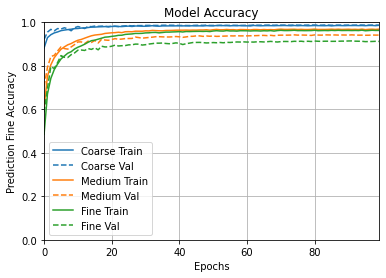

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

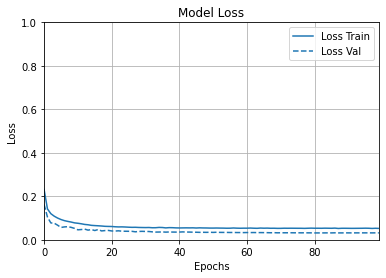

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 16s 40ms/step - loss: 0.0431 - prediction_coarse_loss: 0.0098 - prediction_medium_loss: 0.0440 - prediction_fine_loss: 0.0652 - prediction_coarse_accuracy: 0.9873 - prediction_medium_accuracy: 0.9415 - prediction_fine_accuracy: 0.9124
1. loss ==> 0.04306817799806595
2. prediction_coarse_loss ==> 0.00980504509061575
3. prediction_medium_loss ==> 0.04402633383870125
4. prediction_fine_loss ==> 0.06520169228315353
5. prediction_coarse_accuracy ==> 0.9872999787330627
6. prediction_medium_accuracy ==> 0.9415000081062317
7. prediction_fine_accuracy ==> 0.9124000072479248
313/313 [==============================] - 11s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

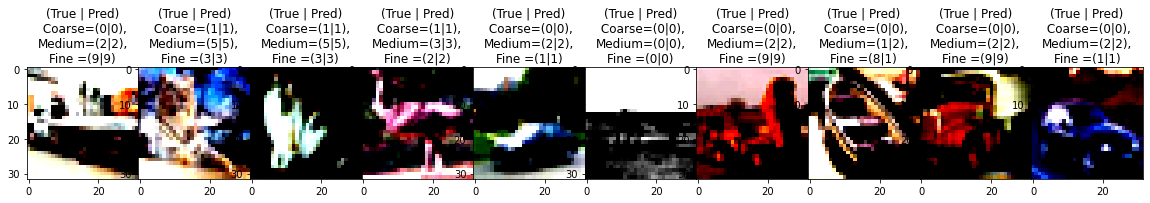

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3945   55]
 [  72 5928]]

  • MEDIUM LEVEL 
[[ 939   15   15   17    3    6    5]
 [  32  939   22    4    0    2    1]
 [  11    4 1977    1    2    3    2]
 [  23    3    3  880   20   47   24]
 [   5    2    1   19  949   19    5]
 [  14    3   10   23   36 1859   55]
 [  17    2    2   25   17   65 1872]]

  • FINE LEVEL 
[[939   8  17   5   2   1   3   4  15   6]
 [  5 969   0   0   1   0   0   0   1  24]
 [ 25   0 880  29  11  17  23  10   3   2]
 [ 10   1  16 810  19  90  30  14   3   7]
 [  9   1  19  25 897  14  20  13   2   0]
 [  4   2  16  85  15 860   7  10   0   1]
 [  4   0  20  12   3   5 952   1   2   1]
 [  8   0  10  12  20  13   1 934   1   1]
 [ 31  12   5   1   0   1   0   1 942   7]
 [  8  40   1   2   0   1   2   1   4 941]]

  • Classification Report 


  • COARSE LEVEL 


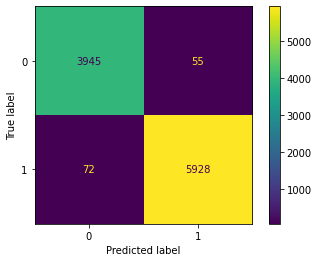

              precision    recall  f1-score   support

           0    0.98208   0.98625   0.98416      4000
           1    0.99081   0.98800   0.98940      6000

    accuracy                        0.98730     10000
   macro avg    0.98644   0.98713   0.98678     10000
weighted avg    0.98731   0.98730   0.98730     10000


  • MEDIUM LEVEL 


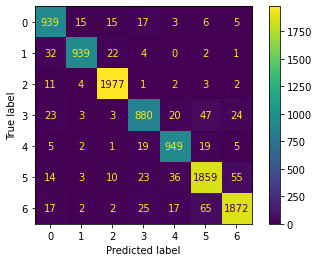

              precision    recall  f1-score   support

           0    0.90202   0.93900   0.92014      1000
           1    0.97004   0.93900   0.95427      1000
           2    0.97389   0.98850   0.98114      2000
           3    0.90815   0.88000   0.89385      1000
           4    0.92405   0.94900   0.93636      1000
           5    0.92904   0.92950   0.92927      2000
           6    0.95316   0.93600   0.94450      2000

    accuracy                        0.94150     10000
   macro avg    0.93719   0.93729   0.93708     10000
weighted avg    0.94164   0.94150   0.94144     10000


  • FINE LEVEL 


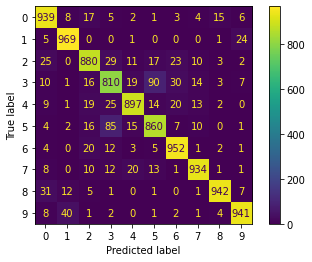

              precision    recall  f1-score   support

           0    0.90029   0.93900   0.91924      1000
           1    0.93804   0.96900   0.95327      1000
           2    0.89431   0.88000   0.88710      1000
           3    0.82569   0.81000   0.81777      1000
           4    0.92665   0.89700   0.91159      1000
           5    0.85828   0.86000   0.85914      1000
           6    0.91715   0.95200   0.93425      1000
           7    0.94534   0.93400   0.93964      1000
           8    0.96814   0.94200   0.95489      1000
           9    0.95051   0.94100   0.94573      1000

    accuracy                        0.91240     10000
   macro avg    0.91244   0.91240   0.91226     10000
weighted avg    0.91244   0.91240   0.91226     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9464950000000001 
Hierarchical Recall = 0.9483 
Hierarchical F1-Score = 0.9472535714285714 
Consistency =  0.9898 
Exact Match =  0.9093
